# CIFAR10 Image Classification

Fast-forward to 2012, and we move on to the deeper and more modern AlexNet architecture. We will use the CIFAR10 dataset that uses 60,000 ImageNet samples, compressed to 32x32 pixel resolution (from the original 224x224), but still with three color channels. There are only 10 of the original 1,000 classes. See the notebook cifar10_image_classification for implementation details; we will skip here over some repetitive steps. 

## Run inside docker container for GPU acceleration

See [tensorflow guide](https://www.tensorflow.org/install/docker) and more detailed [instructions](https://blog.sicara.com/tensorflow-gpu-opencv-jupyter-docker-10705b6cd1d)

`docker run -it -p 8889:8888 -v /path/to/machine-learning-for-trading/17_convolutions_neural_nets:/cnn --name tensorflow tensorflow/tensorflow:latest-gpu-py3 bash`

Inside docker container: 
`jupyter notebook --ip 0.0.0.0 --no-browser --allow-root`

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import backend as K

In [2]:
sns.set_style('whitegrid')
np.random.seed(42)

## Load CIFAR-10 Data

CIFAR10 can also be downloaded from keras, and we similarly rescale the pixel values and one-hot encode the ten class labels. 

In [3]:
# load the pre-shuffled train and test data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

### Visualize the First 30 Training Images

In [4]:
cifar10_labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [5]:
num_classes = len(cifar10_labels)

In [6]:
height, width, channels = X_train.shape[1:]
input_shape = height, width, channels
input_shape

(32, 32, 3)

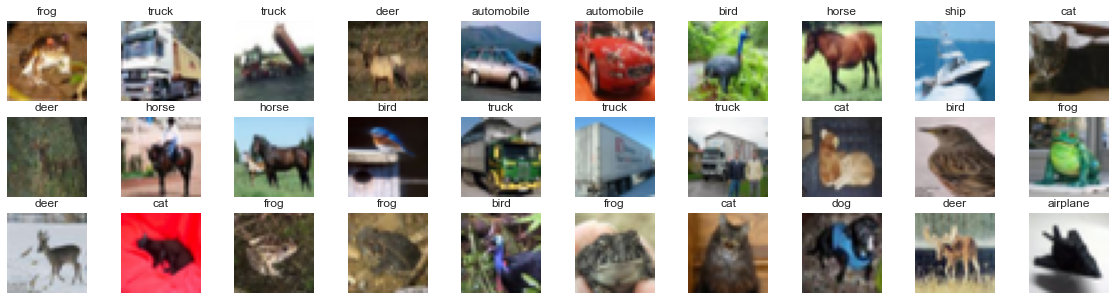

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(np.squeeze(X_train[i]))
    ax.axis('off')
    ax.set_title(cifar10_labels[y_train[i, 0]])

### Rescale the Images

In [8]:
# rescale [0,255] --> [0,1]
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

### Train-Test split

In [10]:
X_train, X_valid = X_train[5000:], X_train[:5000]
y_train, y_valid = y_train[5000:], y_train[:5000]

In [11]:
# shape of training set
X_train.shape

(45000, 32, 32, 3)

In [12]:
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
print(X_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## Feedforward Neural Network

We first train a two-layer feedforward network on 50,000 training samples for training for 20 epochs to achieve a test accuracy of 44.22%. We also experiment with a three-layer convolutional net with 500K parameters for 67.07% test accuracy.

### Model Architecture 

In [13]:
mlp = Sequential([
    Flatten(input_shape=input_shape, name='input'),
    Dense(1000, activation='relu', name='hidden_layer_1'),
    Dropout(0.2, name='droput_1'),
    Dense(512, activation='relu', name='hidden_layer_2'),
    Dropout(0.2, name='dropout_2'),
    Dense(num_classes, activation='softmax', name='output')
])

In [14]:
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 1000)              3073000   
_________________________________________________________________
droput_1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 3,590,642
Trainable params: 3,590,642
Non-trainable params: 0
______________________________________________

### Compile the Model 

In [15]:
mlp.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [16]:
mlp_path = 'models/cifar10.mlp.weights.best.hdf5'

In [17]:
checkpointer = ModelCheckpoint(filepath=mlp_path,
                               verbose=1,
                               save_best_only=True)

In [18]:
tensorboard = TensorBoard(log_dir='./logs/mlp',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)

### Train the Model 

In [20]:
batch_size = 32
epochs = 100

In [21]:
mlp_history = mlp.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=1,
                      shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
44256/45000 [============================>.] - ETA: 0s - loss: 2.0198 - accuracy: 0.2585
Epoch 00001: val_loss improved from inf to 1.82856, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 4s 78us/sample - loss: 2.0174 - accuracy: 0.2592 - val_loss: 1.8286 - val_accuracy: 0.3380
Epoch 2/100
44896/45000 [============================>.] - ETA: 0s - loss: 1.8738 - accuracy: 0.3148
Epoch 00002: val_loss improved from 1.82856 to 1.79139, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 3s 67us/sample - loss: 1.8733 - accuracy: 0.3151 - val_loss: 1.7914 - val_accuracy: 0.3432
Epoch 3/100
44640/45000 [============================>.] - ETA: 0s - loss: 1.8359 - accuracy: 0.3280
Epoch 00003: val_loss improved from 1.79139 to 1.75857, saving model to models/cifar10.mlp.weights.best.hdf5
45000/45000 [==============================] - 3s

Epoch 27/100
44544/45000 [============================>.] - ETA: 0s - loss: 1.6517 - accuracy: 0.3978
Epoch 00027: val_loss did not improve from 1.60848
45000/45000 [==============================] - 3s 66us/sample - loss: 1.6522 - accuracy: 0.3974 - val_loss: 1.6594 - val_accuracy: 0.4006
Epoch 28/100
44800/45000 [============================>.] - ETA: 0s - loss: 1.6480 - accuracy: 0.3990
Epoch 00028: val_loss did not improve from 1.60848
45000/45000 [==============================] - 3s 67us/sample - loss: 1.6477 - accuracy: 0.3992 - val_loss: 1.6456 - val_accuracy: 0.4108
Epoch 29/100
44384/45000 [============================>.] - ETA: 0s - loss: 1.6473 - accuracy: 0.4004
Epoch 00029: val_loss did not improve from 1.60848
45000/45000 [==============================] - 3s 69us/sample - loss: 1.6469 - accuracy: 0.4005 - val_loss: 1.6351 - val_accuracy: 0.4048


### Plot CV Results

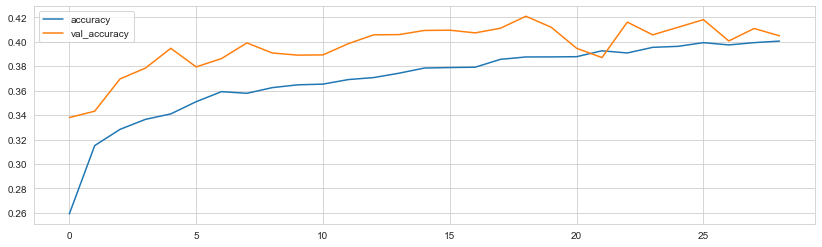

In [23]:
pd.DataFrame(mlp_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4))

### Load best model

In [24]:
# load the weights that yielded the best validation accuracy
mlp.load_weights(mlp_path)

### Test Classification Accuracy

In [68]:
# evaluate and print test accuracy
mlp_accuracy = mlp.evaluate(X_test, y_test, verbose=0)[1]
print('Test accuracy: {:.2%}'.format(mlp_accuracy))

Test accuracy: 43.05%


## Convolutional Neural Network

In [26]:
# https://stackoverflow.com/questions/35114376/error-when-computing-summaries-in-tensorflow/35117760#35117760
K.clear_session()

### Model Architecture

In [27]:
cnn = Sequential([
    Conv2D(filters=16,
           kernel_size=2,
           padding='same',
           activation='relu',
           input_shape=input_shape,
           name='CONV1'),
    MaxPooling2D(pool_size=2, name='POOL1'),
    Conv2D(filters=32,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=2, name='POOL2'),
    Conv2D(filters=64,
           kernel_size=2,
           padding='same',
           activation='relu',
           name='CONV3'),
    MaxPooling2D(pool_size=2, name='POOL3'),
    Dropout(0.3, name='DROP1'),
    Flatten(name='FLAT1'),
    Dense(500, activation='relu', name='FC1'),
    Dropout(0.4, name='DROP2'),
    Dense(10, activation='softmax', name='FC2')
])

In [28]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 32, 32, 16)        208       
_________________________________________________________________
POOL1 (MaxPooling2D)         (None, 16, 16, 16)        0         
_________________________________________________________________
CONV2 (Conv2D)               (None, 16, 16, 32)        2080      
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 8, 8, 32)          0         
_________________________________________________________________
CONV3 (Conv2D)               (None, 8, 8, 64)          8256      
_________________________________________________________________
POOL3 (MaxPooling2D)         (None, 4, 4, 64)          0         
_________________________________________________________________
DROP1 (Dropout)              (None, 4, 4, 64)          0

### Compile the Model

In [29]:
cnn.compile(loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

### Define Callbacks

In [30]:
cnn_path = 'models/cifar10.cnn.weights.best.hdf5'

In [31]:
checkpointer = ModelCheckpoint(filepath=cnn_path,
                               verbose=1,
                               save_best_only=True)

In [32]:
tensorboard = TensorBoard(log_dir='./logs/cnn',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

### Train the Model

In [33]:
batch_size = 32
epochs = 100

In [34]:
cnn_history = cnn.fit(X_train,
                      y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(X_valid, y_valid),
                      callbacks=[checkpointer, tensorboard, early_stopping],
                      verbose=2,
                      shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.32836, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 4s - loss: 1.5550 - accuracy: 0.4336 - val_loss: 1.3284 - val_accuracy: 0.5280
Epoch 2/100

Epoch 00002: val_loss improved from 1.32836 to 1.09306, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.2497 - accuracy: 0.5512 - val_loss: 1.0931 - val_accuracy: 0.6068
Epoch 3/100

Epoch 00003: val_loss improved from 1.09306 to 1.01416, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.1251 - accuracy: 0.5991 - val_loss: 1.0142 - val_accuracy: 0.6464
Epoch 4/100

Epoch 00004: val_loss improved from 1.01416 to 0.91805, saving model to models/cifar10.cnn.weights.best.hdf5
45000/45000 - 3s - loss: 1.0414 - accuracy: 0.6287 - val_loss: 0.9181 - val_accuracy: 0.6848
Epoch 5/100

Epoch 00005: val_loss improved from 0.91805 to 0.88759, saving model to models/cif

### Plot CV Results

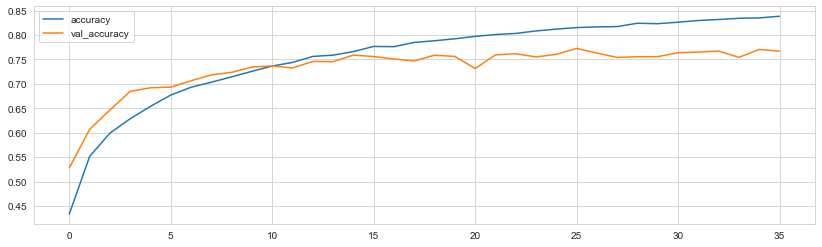

In [35]:
pd.DataFrame(cnn_history.history)[['accuracy',
                                   'val_accuracy']].plot(figsize=(14, 4));

### Load best model

In [69]:
cnn.load_weights(cnn_path)

### Test set accuracy

In [70]:
cnn_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Accuracy: {:.2%}'.format(cnn_accuracy))

Accuracy: 75.39%


### Evaluate Predictions

In [38]:
y_hat = cnn.predict(X_test)

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t-dl/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 10003 missing from current font.
  font.set_text(s, 0, flags=flags)


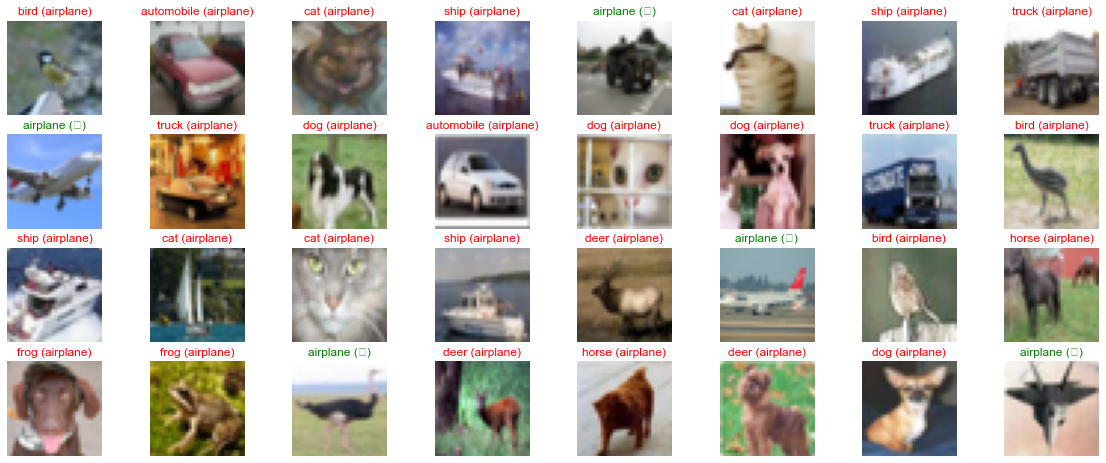

In [39]:
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20, 8))
axes = axes.flatten()
images = np.random.choice(X_test.shape[0], size=32, replace=False)
for i, (ax, idx) in enumerate(zip(axes, images)):
    ax.imshow(np.squeeze(X_test[idx]))
    ax.axis('off')
    pred_idx, true_idx = np.argmax(y_hat[idx]), np.argmax(y_test[idx])
    if pred_idx == true_idx:
        ax.set_title('{} (✓)'.format(cifar10_labels[pred_idx]), color="green")
    else:
        ax.set_title("{} ({})".format(cifar10_labels[pred_idx],
                                      cifar10_labels[true_idx]),
                     color='red')

## CNN with Image Augmentation

A common trick to enhance performance is to artificially increase the size of the training set by creating synthetic data. This involves randomly shifting or horizontally flipping the image, or introducing noise into the image.

### Create and configure augmented image generator

Keras includes an ImageDataGenerator for this purpose that we can configure and fit to the training data as follows:

In [40]:
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly horizontal shift
    height_shift_range=0.1,  # randomly vertial shift
    horizontal_flip=True)  # randomly horizontalflip

In [41]:
# fit augmented image generator on data
datagen.fit(X_train)

### Visualize subset of training data

The result shows how the augmented images have been altered in various ways as expected:

In [42]:
n_images = 6
x_train_subset = X_train[:n_images]

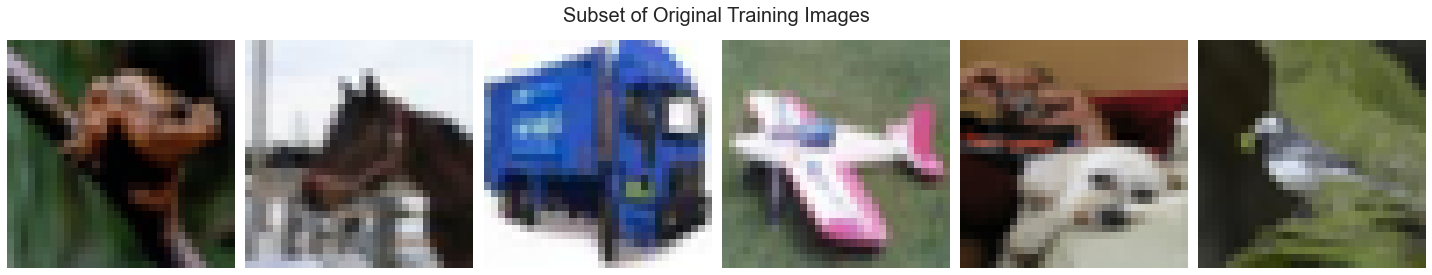

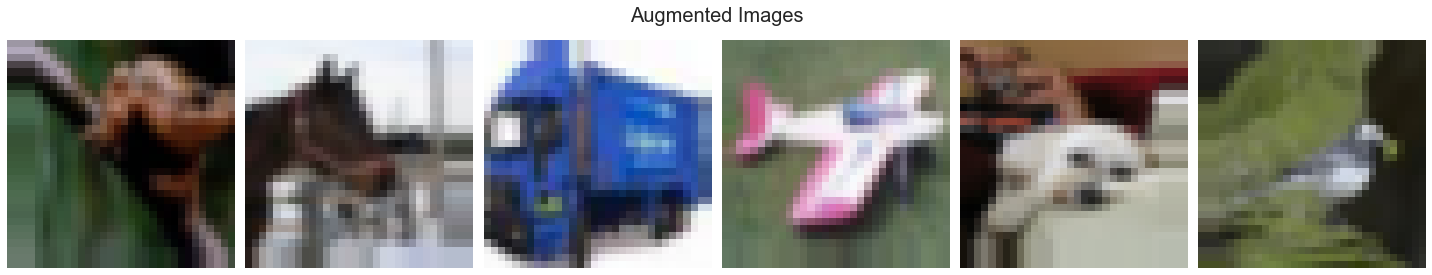

In [43]:
# original images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for i, (ax, img) in enumerate(zip(axes, x_train_subset)):
    ax.imshow(img)
    ax.axis('off')
fig.suptitle('Subset of Original Training Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/original')

# augmented images
fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(20, 4))
for x_batch in datagen.flow(x_train_subset, batch_size=n_images,
                            shuffle=False):
    for i, ax in enumerate(axes):
        ax.imshow(x_batch[i])
        ax.axis('off')
#     fig.suptitle('Augmented Images', fontsize=20)
    break
fig.suptitle('Augmented Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig('images/augmented')

### Define Callbacks

In [44]:
K.clear_session()

In [45]:
cnn_aug_path = 'models/cifar10.augmented.cnn.weights.best.hdf5'

In [46]:
checkpointer = ModelCheckpoint(filepath=cnn_aug_path,
                               verbose=1,
                               save_best_only=True)

In [47]:
tensorboard = TensorBoard(log_dir='./logs/cnn_aug',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

### Train Augmented Images

In [48]:
batch_size = 32
epochs = 100

In [49]:
cnn_aug_history = cnn.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                          steps_per_epoch=X_train.shape[0] // batch_size,
                          epochs=epochs,
                          validation_data=(X_valid, y_valid),
                          callbacks=[checkpointer, tensorboard, early_stopping],
                          verbose=2)

  ...
    to  
  ['...']
Train for 1406 steps, validate on 5000 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.77811, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.9847 - accuracy: 0.6609 - val_loss: 0.7781 - val_accuracy: 0.7338
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.77811
1406/1406 - 13s - loss: 0.9361 - accuracy: 0.6752 - val_loss: 0.7941 - val_accuracy: 0.7282
Epoch 3/100

Epoch 00003: val_loss improved from 0.77811 to 0.76473, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.9111 - accuracy: 0.6848 - val_loss: 0.7647 - val_accuracy: 0.7388
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.76473
1406/1406 - 13s - loss: 0.8942 - accuracy: 0.6871 - val_loss: 0.7648 - val_accuracy: 0.7360
Epoch 5/100

Epoch 00005: val_loss improved from 0.76473 to 0.71438, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.8884 - accurac

Epoch 47/100

Epoch 00047: val_loss did not improve from 0.60708
1406/1406 - 13s - loss: 0.7340 - accuracy: 0.7427 - val_loss: 0.6346 - val_accuracy: 0.7842
Epoch 48/100

Epoch 00048: val_loss did not improve from 0.60708
1406/1406 - 13s - loss: 0.7344 - accuracy: 0.7438 - val_loss: 0.6102 - val_accuracy: 0.7950
Epoch 49/100

Epoch 00049: val_loss improved from 0.60708 to 0.59920, saving model to models/cifar10.augmented.cnn.weights.best.hdf5
1406/1406 - 13s - loss: 0.7394 - accuracy: 0.7409 - val_loss: 0.5992 - val_accuracy: 0.7928
Epoch 50/100

Epoch 00050: val_loss did not improve from 0.59920
1406/1406 - 13s - loss: 0.7357 - accuracy: 0.7414 - val_loss: 0.6421 - val_accuracy: 0.7776
Epoch 51/100

Epoch 00051: val_loss did not improve from 0.59920
1406/1406 - 13s - loss: 0.7371 - accuracy: 0.7415 - val_loss: 0.6102 - val_accuracy: 0.7942
Epoch 52/100

Epoch 00052: val_loss did not improve from 0.59920
1406/1406 - 13s - loss: 0.7290 - accuracy: 0.7450 - val_loss: 0.6302 - val_accurac

### Plot CV Result

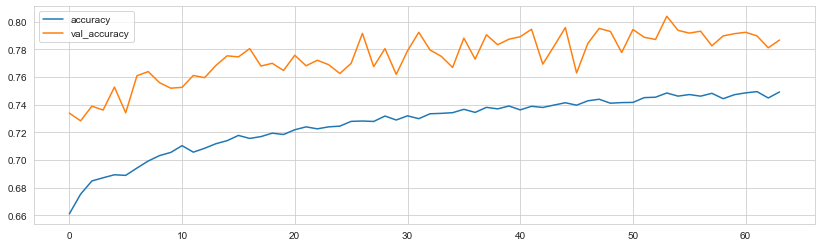

In [51]:
pd.DataFrame(cnn_aug_history.history)[['accuracy',
                                       'val_accuracy']].plot(figsize=(14, 4));

### Load best model

In [72]:
cnn.load_weights(cnn_aug_path)

### Test set accuracy

The test accuracy for the three-layer CNN improves markedly to 74.79% after training on the larger, augmented data.

In [73]:
cnn_aug_accuracy = cnn.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(cnn_aug_accuracy))

Test Accuracy: 78.29%


## AlexNet

We also need to simplify the AlexNet architecture in response to the lower dimensionality of CIFAR10 images relative to the ImageNet samples used in the competition. We use the original number of filters but make them smaller (see notebook for implementation). The summary shows the five convolutional layers followed by two fully-connected layers with frequent use of batch normalization, for a total of 21.5 million parameters:

### Define Architecture

In [55]:
K.clear_session()

In [56]:
alexnet = Sequential([

    # 1st Convolutional Layer
    Conv2D(96, (3, 3),
           strides=(2, 2),
           activation='relu',
           padding='same',
           input_shape=input_shape,
           name='CONV_1'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='POOL_1'),
    BatchNormalization(name='NORM_1'),

    # 2nd Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(5, 5),
           padding='same',
           activation='relu',
           name='CONV2'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL2'),
    BatchNormalization(name='NORM_2'),

    # 3rd Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV3'),
    # 4th Convolutional Layer
    Conv2D(filters=384,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV4'),
    # 5th Convolutional Layer
    Conv2D(filters=256,
           kernel_size=(3, 3),
           padding='same',
           activation='relu',
           name='CONV5'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='POOL5'),
    BatchNormalization(name='NORM_5'),

    # Fully Connected Layers
    Flatten(name='FLAT'),
    Dense(4096, input_shape=(32 * 32 * 3, ), activation='relu', name='FC1'),
    Dropout(0.4, name='DROP1'),
    Dense(4096, activation='relu', name='FC2'),
    Dropout(0.4, name='DROP2'),
    Dense(num_classes, activation='softmax')
])

In [57]:
alexnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV_1 (Conv2D)              (None, 16, 16, 96)        2688      
_________________________________________________________________
POOL_1 (MaxPooling2D)        (None, 8, 8, 96)          0         
_________________________________________________________________
NORM_1 (BatchNormalization)  (None, 8, 8, 96)          384       
_________________________________________________________________
CONV2 (Conv2D)               (None, 8, 8, 256)         614656    
_________________________________________________________________
POOL2 (MaxPooling2D)         (None, 3, 3, 256)         0         
_________________________________________________________________
NORM_2 (BatchNormalization)  (None, 3, 3, 256)         1024      
_________________________________________________________________
CONV3 (Conv2D)               (None, 3, 3, 384)         8

### Compile Model

In [58]:
alexnet.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

### Define Callbacks

In [59]:
alexnet_path = 'models/cifar10.augmented.alexnet.weights.best.hdf5'

In [60]:
checkpointer = ModelCheckpoint(filepath=alexnet_path,
                               verbose=1,
                               save_best_only=True)

In [61]:
tensorboard = TensorBoard(log_dir='./logs/alexnet',
                          histogram_freq=1,
                          write_graph=True,
                          write_grads=False,
                          update_freq='epoch')

### Train Model

In [62]:
batch_size = 32
epochs = 100

In [63]:
alex_history = alexnet.fit(datagen.flow(X_train,
                                        y_train,
                                        batch_size=batch_size),
                           steps_per_epoch=X_train.shape[0] // batch_size,
                           epochs=epochs,
                           validation_data=(X_valid, y_valid),
                           callbacks=[checkpointer, tensorboard, early_stopping],
                           verbose=1)

  ...
    to  
  ['...']
Train for 1406 steps, validate on 5000 samples
Epoch 1/100
1404/1406 [============================>.] - ETA: 0s - loss: 1.6620 - accuracy: 0.4029
Epoch 00001: val_loss improved from inf to 1.43729, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
1406/1406 [==============================] - 16s 12ms/step - loss: 1.6618 - accuracy: 0.4030 - val_loss: 1.4373 - val_accuracy: 0.5166
Epoch 2/100
1405/1406 [============================>.] - ETA: 0s - loss: 1.3615 - accuracy: 0.5259
Epoch 00002: val_loss improved from 1.43729 to 1.15542, saving model to models/cifar10.augmented.alexnet.weights.best.hdf5
1406/1406 [==============================] - 16s 11ms/step - loss: 1.3615 - accuracy: 0.5259 - val_loss: 1.1554 - val_accuracy: 0.6088
Epoch 3/100
1404/1406 [============================>.] - ETA: 0s - loss: 1.1616 - accuracy: 0.5985
Epoch 00003: val_loss did not improve from 1.15542
1406/1406 [==============================] - 15s 11ms/step - loss: 1

1406/1406 [==============================] - 16s 11ms/step - loss: 0.4030 - accuracy: 0.8674 - val_loss: 1.2734 - val_accuracy: 0.7578
Epoch 27/100
1405/1406 [============================>.] - ETA: 0s - loss: 0.4051 - accuracy: 0.8672
Epoch 00027: val_loss did not improve from 0.62606
1406/1406 [==============================] - 15s 11ms/step - loss: 0.4051 - accuracy: 0.8673 - val_loss: 0.6288 - val_accuracy: 0.8084
Epoch 28/100
1402/1406 [============================>.] - ETA: 0s - loss: 0.3647 - accuracy: 0.8781
Epoch 00028: val_loss did not improve from 0.62606
1406/1406 [==============================] - 15s 11ms/step - loss: 0.3647 - accuracy: 0.8781 - val_loss: 0.7682 - val_accuracy: 0.7990
Epoch 29/100
1402/1406 [============================>.] - ETA: 0s - loss: 0.3546 - accuracy: 0.8814
Epoch 00029: val_loss did not improve from 0.62606
1406/1406 [==============================] - 15s 11ms/step - loss: 0.3546 - accuracy: 0.8815 - val_loss: 0.7297 - val_accuracy: 0.7762
Epoch 3

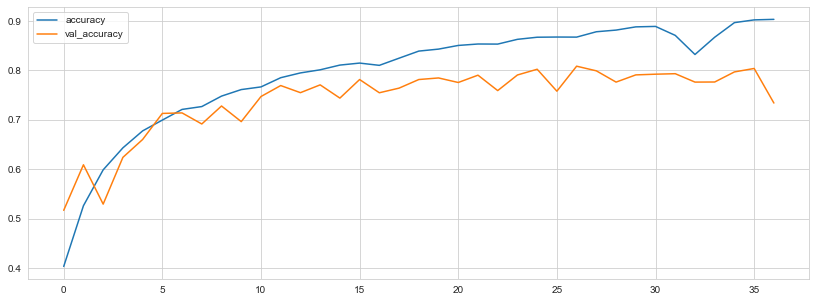

In [64]:
pd.DataFrame(alex_history.history)[['accuracy',
                               'val_accuracy']].plot(figsize=(14, 5))

In [65]:
alexnet.load_weights(alexnet_path)

After training for 20 episodes, each of which takes a little under 30 seconds on a single GPU, we obtain 76.84% test accuracy.

In [74]:
alex_accuracy = alexnet.evaluate(X_test, y_test, verbose=0)[1]
print('Test Accuracy: {:.2%}'.format(alex_accuracy))

Test Accuracy: 79.33%


## Compare Results

In [87]:
cv_results = pd.DataFrame(
    {'Feed-Forward NN': pd.Series(mlp_history.history['val_accuracy']),
        'CNN': pd.Series(cnn_history.history['val_accuracy']),
        'CNN Aug.': pd.Series(cnn_aug_hist.history['val_accuracy']),
        'Alex Net': pd.Series(alex_history.history['val_accuracy'])
    })
test_accuracy = pd.Series({
    'Feed-Forward NN': mlp_accuracy,
    'CNN': cnn_accuracy,
    'CNN Aug.': cnn_aug_accuracy,
    'Alex Net': alex_accuracy
})

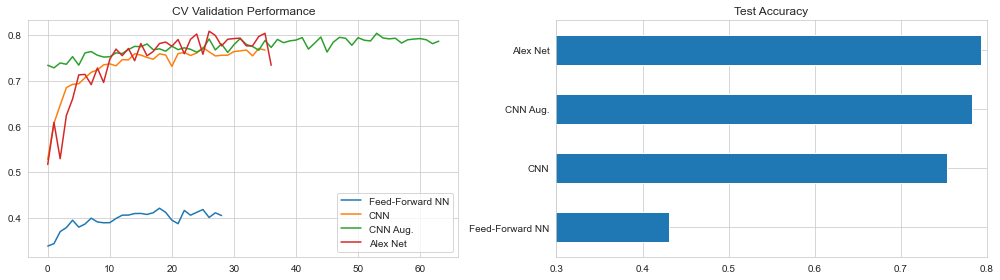

In [94]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4))
cv_results.plot(ax=axes[0], title='CV Validation Performance')
test_accuracy.plot.barh(ax=axes[1], xlim=(.3, .8), title='Test Accuracy')
fig.tight_layout()
fig.savefig('figures/cifar_comparison', dpi=300);

## TensorBoard visualization

In [1]:
%load_ext tensorboard

In [2]:
%tensorboard --logdir logs/alexnet